# CNN-Based SameGame RL Experiment

This notebook implements a Deep Q-Network (DQN) agent using a Convolutional Neural Network to learn optimal SameGame strategies. The CNN architecture is designed to capture spatial patterns in the game board that are crucial for effective tile-clearing decisions.

## Experiment Configuration

Setting up the basic experiment parameters and metadata.

In [1]:
experiment_name = "CNN_simple_reward_base"

## Import Dependencies

Loading all necessary modules for the experiment.

In [2]:
from samegamerl.environments.samegame_env import SameGameEnv
from samegamerl.agents.dqn_agent import DqnAgent
from samegamerl.evaluation.plot_helper import plot_evals, plot_result
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn
from samegamerl.evaluation.validator import validate
from samegamerl.game.game_config import GameConfig, GameFactory
#from samegamerl.evaluation.visualize_agent import play_eval_game
from samegamerl.training.train import train
from samegamerl.agents.replay_buffer import ReplayBuffer

## Neural Network Architecture

Defining a CNN model that processes the game board as a multi-channel image. The architecture uses:
- Convolutional layers to detect local tile patterns
- Global average pooling to aggregate spatial information
- Fully connected layers for action value estimation

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, config: GameConfig):
        super().__init__()
        self.config = config
        self.conv_stack = nn.Sequential(
            nn.Conv2d(config.num_colors, 64, 3, padding=1),
            nn.ReLU(),
            # nn.MaxPool2d((2,2), (2,2)),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            # nn.MaxPool2d((2,2), (2,2)),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(128, 256), nn.ReLU(), nn.Linear(256, config.action_space_size)
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.global_pool(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

## Hyperparameters

Configuration of training parameters, exploration strategy, and reporting intervals.

In [ ]:
# Training specific parameters
batch_size = 1024
n_games = 5_000
max_steps = 30  # Maximum steps per episode

# Training intervals
update_target_num = 100    # Target network update frequency
report_num = 500             # Progress reporting interval
visualize_num = 0            # Visualization frequency
initial_update_done = n_games // 2

# Agent hyperparameters
learning_rate = 0.0001
start_epsilon = 1.0           # Initial exploration rate
epsilon_decay = start_epsilon / n_games
final_epsilon = 0.1           # Minimum exploration rate
gamma = 0.95                   # Discount factor
tau = 0.05

## Environment and Agent Setup

Creating the SameGame environment and DQN agent with the CNN model.

In [ ]:
# Use medium game configuration (8x8 board with 3 colors)
config = GameFactory.medium()

# Initialize environment and agent
env = SameGameEnv(config, partial_completion_base=5)
agent = DqnAgent(
    model=NeuralNetwork(config),
    config=config,
    model_name=experiment_name,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    gamma=gamma,
    batch_size=batch_size,
)

agent.replay_buffer = ReplayBuffer(capacity=50_000)

Using cuda device


## Load Pre-trained Model (Optional)

Loading a previously trained model to continue training from a checkpoint.

In [6]:
# Uncomment to load a pre-trained model
agent.load()

Model loaded from samegamerl/models/CNN_simple_reward_base.pth


## Training Loop

Execute the main training process using the configured parameters.

In [7]:
results = train(
    agent,
    env,
    epochs=n_games,
    max_steps=max_steps,
    report_num=report_num,
    visualize_num=visualize_num,
    update_target_num=update_target_num,
)

# Save the trained model
agent.save()

100%|██████████| 5000/5000 [22:04<00:00,  3.78it/s]

Model saved to samegamerl/models/CNN_simple_reward_base.pth


## Training Results Visualization

Plot the training progress to analyze learning performance.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


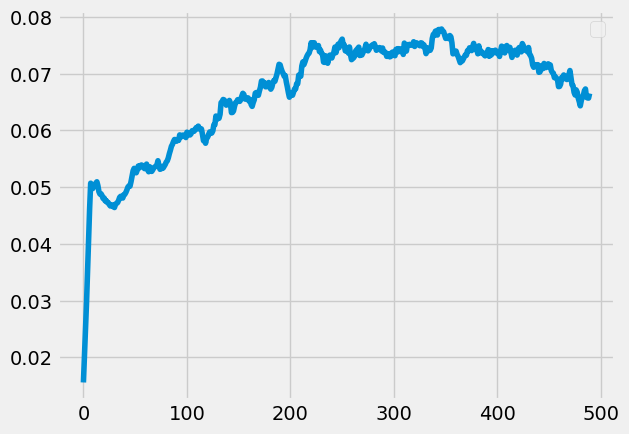

In [8]:
plot_result(results, interval=10)

## Agent Evaluation

Evaluate the trained agent's performance on a validation set.

100%|██████████| 1000/1000 [01:11<00:00, 14.03it/s]


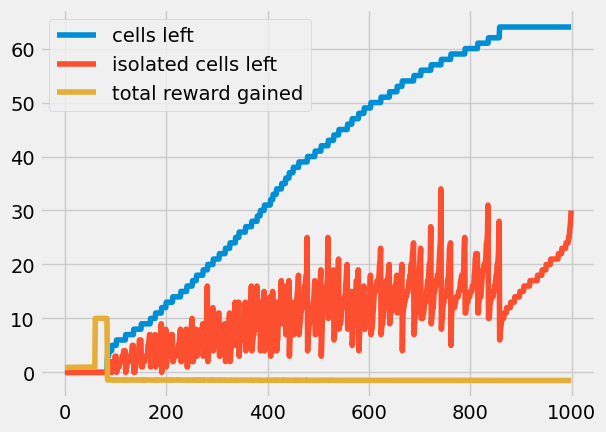

Wins: 84, Losses: 0


In [9]:
wins, losses, evals = validate(agent, num_games=1000)
plot_evals(evals)
print(f"Wins: {wins}, Losses: {losses}")

## Interactive Game Visualization (Optional)

Watch the trained agent play the game interactively.

In [10]:
# Uncomment to watch the agent play
# play_eval_game(agent, visualize=True, waiting_time=500)